In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
import wrangle as w

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import random 
random.seed(10)
import re

In [3]:
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')

In [71]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [4]:
df = pd.read_csv('pivot_final_3.csv')

In [5]:
df.head()

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win
0,Rex Grossman,WAS,2010,4.0,74.0,133.0,55.6,884.0,6.6,7.0,4.0,81.16,3.0,6.0,2.0,0.0,Rex Grossman,2015,0.7,Rex Grossman,30,5.3,3.0,42,64,11.9,221.0,33.000000,9,0.0,1.0,1,2,0.0,0.0,0.0,0.0,0.0
1,Rex Grossman,WAS,2011,13.0,265.0,458.0,57.9,3148.0,6.9,16.0,20.0,72.39,20.0,11.0,0.6,1.0,Rex Grossman,2015,0.7,Rex Grossman,31,3.5,4.4,161,51,11.9,242.4,41.500000,25,2.0,2.0,5,8,0.0,0.0,0.0,0.0,0.0
2,Matt Flynn,GB,2013,7.0,124.0,200.0,62.0,1392.0,7.0,8.0,5.0,85.67,20.0,65.0,3.2,0.0,Matt Flynn,2013,4.7,Matt Flynn,28,4.0,2.5,0,56,11.2,198.9,52.597577,24,3.0,2.0,2,3,1.0,0.0,0.0,0.0,0.0
3,Matt Flynn,GB,2013,7.0,124.0,200.0,62.0,1392.0,7.0,8.0,5.0,85.67,20.0,65.0,3.2,0.0,Matt Flynn,2013,0.7,Matt Flynn,28,4.0,2.5,0,56,11.2,198.9,52.597577,24,3.0,2.0,2,3,1.0,0.0,0.0,0.0,0.0
4,Jameis Winston,TB,2015,16.0,312.0,535.0,58.3,4042.0,7.6,22.0,15.0,84.19,54.0,213.0,3.9,6.0,Jameis Winston,2015,4.4,Jameis Winston,21,4.1,2.8,201,68,13.0,252.6,57.200000,27,2.0,3.0,6,10,0.0,0.0,0.0,0.0,0.0


In [6]:
df['win_perc'] = round((df.win / df.games_played),2)
df['loss_perc'] = round((df.loss / df.games_played), 2)
df['td_per_game'] = round((df.td / df.games_played),2)
df['sk_per_game'] = round((df.Sk / df.games_played), 2)

In [19]:
df[df.name == 'Andy Dalton']

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game
100,Andy Dalton,CIN,2011,16.0,300.0,516.0,58.1,3398.0,6.6,20.0,13.0,80.39,37.0,152.0,4.1,1.0,Andy Dalton,2011,1.1,Andy Dalton,24,3.9,2.5,151,84,11.3,212.4,49.5,24,4.0,4.0,9,7,1.0,0.0,0.0,0.0,0.0,0.56,0.44,1.25,1.50
101,Andy Dalton,CIN,2012,16.0,329.0,528.0,62.3,3669.0,6.9,27.0,16.0,87.38,47.0,120.0,2.6,4.0,Andy Dalton,2014,12.0,Andy Dalton,25,5.1,3.0,172,59,11.2,229.3,47.7,46,1.0,3.0,10,6,1.0,0.0,0.0,0.0,0.0,0.62,0.38,1.69,2.88
102,Andy Dalton,CIN,2013,16.0,363.0,586.0,61.9,4296.0,7.3,33.0,20.0,88.80,61.0,183.0,3.0,2.0,Andy Dalton,2014,12.0,Andy Dalton,26,5.6,3.4,206,82,11.8,268.3,54.8,29,1.0,3.0,11,5,1.0,0.0,0.0,0.0,0.0,0.69,0.31,2.06,1.81
103,Andy Dalton,CIN,2014,16.0,309.0,482.0,64.1,3398.0,7.0,19.0,17.0,83.32,60.0,169.0,2.8,4.0,Andy Dalton,2014,12.0,Andy Dalton,27,4.0,3.5,160,81,11.0,212.4,49.0,21,4.0,3.0,10,5,1.0,0.0,0.0,0.0,0.0,0.62,0.31,1.19,1.31
104,Andy Dalton,CIN,2015,13.0,255.0,386.0,66.1,3250.0,8.4,25.0,7.0,106.25,57.0,142.0,2.5,3.0,Andy Dalton,2020,1.5,Andy Dalton,28,6.5,1.8,148,80,12.7,250.0,72.5,20,3.0,3.0,10,3,1.0,0.0,0.0,0.0,0.0,0.77,0.23,1.92,1.54
105,Andy Dalton,CIN,2016,16.0,364.0,563.0,64.7,4206.0,7.5,18.0,8.0,91.83,46.0,184.0,4.0,4.0,Andy Dalton,2020,1.5,Andy Dalton,29,3.2,1.4,206,86,11.6,262.9,52.3,41,2.0,1.0,6,9,0.0,0.0,0.0,0.0,0.0,0.38,0.56,1.12,2.56
106,Andy Dalton,CIN,2017,16.0,297.0,496.0,59.9,3320.0,6.7,25.0,12.0,86.59,38.0,99.0,2.6,0.0,Andy Dalton,2020,1.5,Andy Dalton,30,5.0,2.4,163,77,11.2,207.5,44.8,39,3.0,3.0,7,9,0.0,0.0,0.0,0.0,0.0,0.44,0.56,1.56,2.44
107,Andy Dalton,CIN,2018,11.0,226.0,365.0,61.9,2566.0,7.0,21.0,11.0,89.59,16.0,99.0,6.2,0.0,Andy Dalton,2020,1.5,Andy Dalton,31,5.8,3.0,132,49,11.4,233.3,59.4,21,3.0,4.0,5,6,0.0,0.0,0.0,0.0,0.0,0.45,0.55,1.91,1.91
108,Andy Dalton,CIN,2019,13.0,314.0,528.0,59.5,3494.0,6.6,16.0,14.0,78.27,32.0,73.0,2.3,4.0,Andy Dalton,2020,1.5,Andy Dalton,32,3.0,2.7,170,66,11.1,268.8,42.1,37,0.0,0.0,2,11,0.0,0.0,0.0,0.0,0.0,0.15,0.85,1.23,2.85
109,Andy Dalton,DAL,2020,11.0,216.0,333.0,64.9,2169.0,6.5,14.0,8.0,87.28,28.0,114.0,4.1,0.0,Andy Dalton,2020,1.5,Andy Dalton,33,4.2,2.4,116,69,10.0,197.3,46.1,24,2.0,3.0,4,5,0.0,0.0,0.0,0.0,0.0,0.36,0.45,1.27,2.18


In [41]:
rookie = pd.read_clipboard()

In [64]:
rookie.to_csv('rookie', index=False)

In [43]:
# for name in rookie.name:
#     print(len(name))

In [45]:
test_df = df.merge(rookie[['name', 'rookie_year']], 
            left_on =['name', 'year'], 
            right_on = ['name', 'rookie_year'], how = 'left')

In [70]:
# np.where(test_df.rookie_year.isnull(), np.nan, test_df.percent_of_cap)


In [89]:
# set(test_df.name)

In [91]:
master_df = pd.DataFrame()

for i in set(test_df.name):
    star = test_df[test_df.name == i]
    star = star.sort_values(by= ['name','year'])
    star.percent_of_cap = star.percent_of_cap.shift(-1)
    star[['percent_of_cap']] = star[['percent_of_cap']].fillna(method='ffill')
    master_df = pd.concat([master_df, star])

In [127]:
master_df[master_df.name == 'Joe Burrow']

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game
399,Joe Burrow,CIN,2020,10.0,264.0,404.0,65.3,2688.0,6.7,13.0,5.0,89.83,37.0,142.0,3.8,3.0,Joe Burrow,2020,NaN,Joe Burrow,24,3.2,1.2,150,67,10.2,268.8,48.5,32,0.0,0.0,2,7,0.0,0.0,0.0,0.0,0.0,0.2,0.7,1.3,3.2


In [128]:
test_df[test_df.name == 'Joe Burrow']

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game,rookie_year
399,Joe Burrow,CIN,2020,10.0,264.0,404.0,65.3,2688.0,6.7,13.0,5.0,89.83,37.0,142.0,3.8,3.0,Joe Burrow,2020,4.6,Joe Burrow,24,3.2,1.2,150,67,10.2,268.8,48.5,32,0.0,0.0,2,7,0.0,0.0,0.0,0.0,0.0,0.2,0.7,1.3,3.2,2020.0


In [126]:
test_df[test_df.name == 'Andy Dalton'].percent_of_cap.shift(-1)

100    12.0
101    12.0
102    12.0
103     1.5
104     1.5
105     1.5
106     1.5
107     1.5
108     1.5
109     5.5
110     1.4
111     NaN
Name: percent_of_cap, dtype: float64

In [108]:
master_df = master_df.drop(columns='rookie_year')

In [131]:
master_df = master_df.dropna()

In [152]:
master_df.to_csv('last_csv.csv', index=False)

In [312]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return object_cols



def get_numeric_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    
    return num_cols


def nulls_by_col(df):
    """
    This function will:
        - take in a dataframe
        - assign a variable to a Series of total row nulls for ea/column
        - assign a variable to find the percent of rows w/nulls
        - output a df of the two variables.
    """
    num_missing = df.isnull().sum()
    pct_miss = (num_missing / df.shape[0]) * 100
    cols_missing = pd.DataFrame({
                    'num_rows_missing': num_missing,
                    'percent_rows_missing': pct_miss
                    })
    
    return  cols_missing


def nulls_by_row(df, index_id = 'name'):
    """
    """
    num_missing = df.isnull().sum(axis=1)
    pct_miss = (num_missing / df.shape[1]) * 100
    
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': pct_miss})

    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True).reset_index()[[index_id, 'num_cols_missing', 'percent_cols_missing']]
    
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [313]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    # distribution of numerical attributes
    '''
    print(f"""SUMMARY REPORT
=====================================================
          
          
Dataframe head: 
{df.head(3)}
          
=====================================================
          
          
Dataframe info: """)
    df.info()

    print(f"""=====================================================
          
          
Dataframe Description: 
{df.describe().T}
          
=====================================================


nulls in dataframe by column: 
{nulls_by_col(df)}
=====================================================


nulls in dataframe by row: 
{nulls_by_row(df)}
=====================================================
    
    
DataFrame value counts: 
 """)         
    for col in (get_object_cols(df)): 
        print(f"""******** {col.upper()} - Value Counts:
{df[col].value_counts()}
    _______________________________________""")                   
        
    num_cols = len(get_numeric_cols(df))
    num_rows, num_cols_subplot = divmod(num_cols, 3)
    if num_cols_subplot > 0:
        num_rows += 1
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    
    for i, col in enumerate(get_numeric_cols(df)):
        row_idx, col_idx = divmod(i, 3)
        sns.histplot(df[col], ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Histogram of {col}')
    
    plt.tight_layout()
    plt.show()

SUMMARY REPORT
          
          
Dataframe head: 
           name team  year  games_played   comp    att  comp_pct     yds  \
0  Rex Grossman  WAS  2010           4.0   74.0  133.0      55.6   884.0   
1  Rex Grossman  WAS  2011          13.0  265.0  458.0      57.9  3148.0   
2    Matt Flynn   GB  2013           7.0  124.0  200.0      62.0  1392.0   

   avg_yds_per_att    td   int  pass_rating  rush_att  rush_yds  rush_avg  \
0              6.6   7.0   4.0        81.16       3.0       6.0       2.0   
1              6.9  16.0  20.0        72.39      20.0      11.0       0.6   
2              7.0   8.0   5.0        85.67      20.0      65.0       3.2   

   rush_td     full_name  year_signed  percent_of_cap        Player  Age  \
0      0.0  Rex Grossman         2015             0.7  Rex Grossman   30   
1      1.0  Rex Grossman         2015             0.7  Rex Grossman   31   
2      0.0    Matt Flynn         2013             4.7    Matt Flynn   28   

   td_perc  int_perc  fir_d

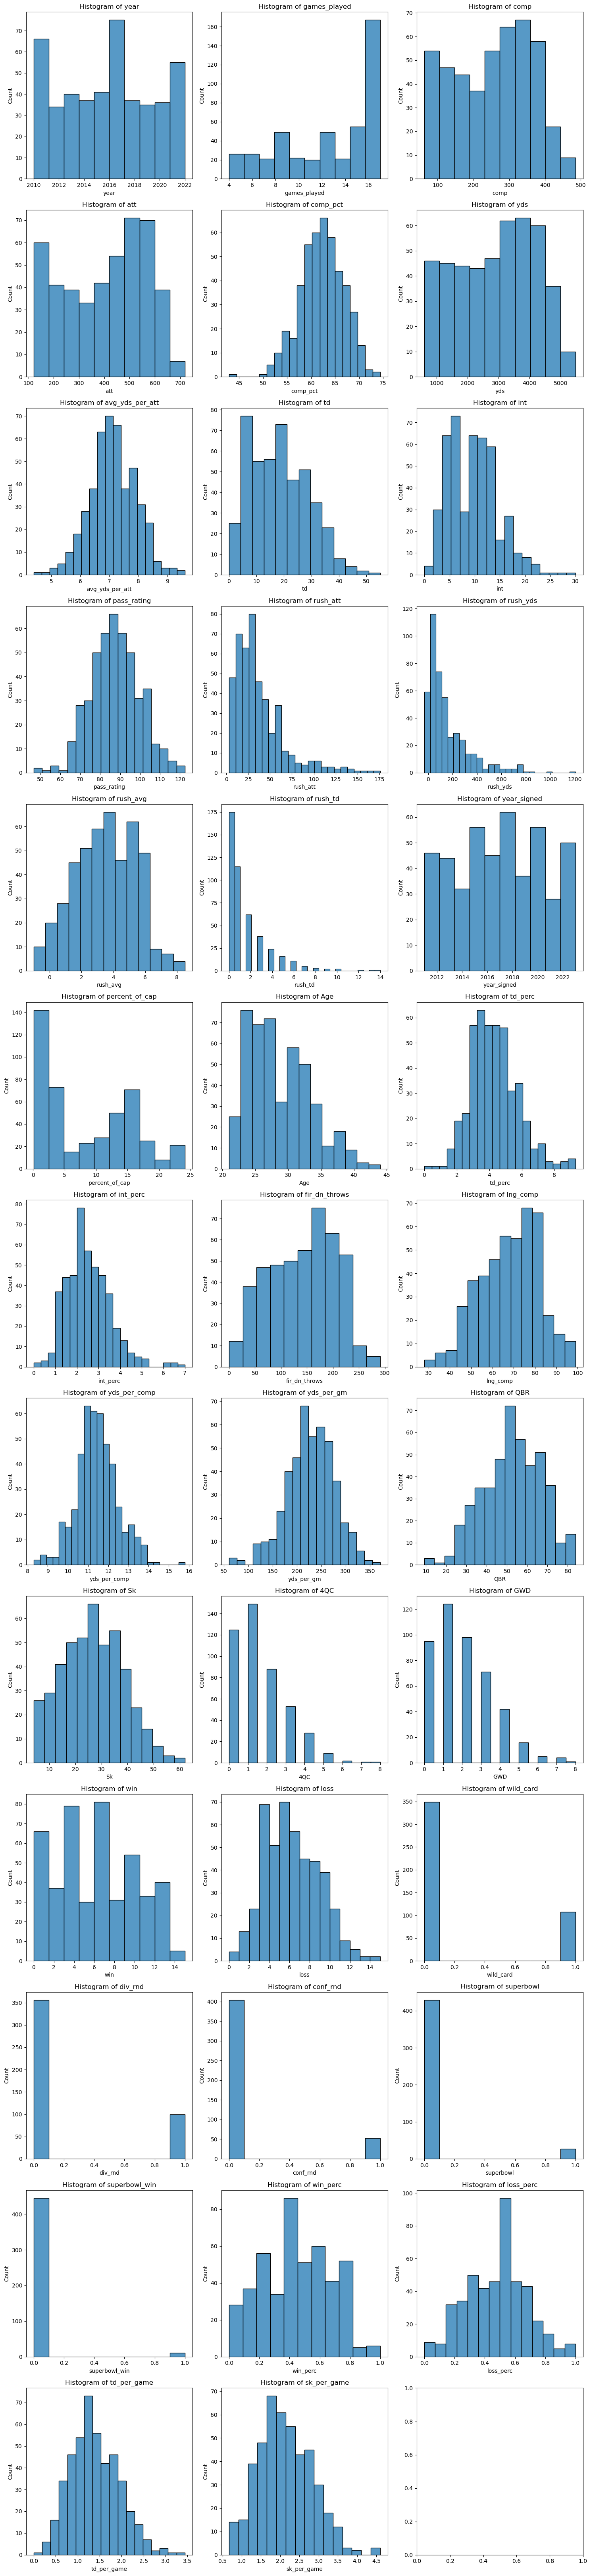

In [317]:
summarize(df)

In [319]:
test = df[df.percent_of_cap > 6]

In [320]:
test

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game
14,Kevin Kolb,PHI,2010,7.0,115.0,189.0,60.8,1197.0,6.3,7.0,7.0,76.09,14.0,68.0,4.9,0.0,Kevin Kolb,2011,10.3,Kevin Kolb,26,3.7,3.7,58,83,10.4,171.0,44.9,15,0.0,0.0,2,3,1.0,0.0,0.0,0.0,0.0,0.29,0.43,1.00,2.14
15,Kevin Kolb,ARI,2011,9.0,146.0,253.0,57.7,1955.0,7.7,9.0,8.0,81.05,17.0,65.0,3.8,0.0,Kevin Kolb,2011,10.3,Kevin Kolb,27,3.6,3.2,87,73,13.4,217.2,33.3,30,2.0,1.0,3,6,0.0,0.0,0.0,0.0,0.0,0.33,0.67,1.00,3.33
36,Alex Smith,SF,2012,16.0,153.0,218.0,70.2,1737.0,8.0,13.0,5.0,104.09,31.0,132.0,4.3,0.0,Alex Smith,2012,6.6,Alex Smith,28,6.0,2.3,87,55,11.4,173.7,65.1,24,0.0,0.0,6,2,0.0,1.0,1.0,1.0,0.0,0.38,0.12,0.81,1.50
37,Alex Smith,KC,2013,15.0,308.0,508.0,60.6,3313.0,6.5,23.0,7.0,89.13,76.0,431.0,5.7,1.0,Alex Smith,2014,12.8,Alex Smith,29,4.5,1.4,168,71,10.8,220.9,45.0,39,1.0,1.0,11,4,1.0,0.0,0.0,0.0,0.0,0.73,0.27,1.53,2.60
38,Alex Smith,KC,2014,15.0,303.0,464.0,65.3,3265.0,7.0,18.0,6.0,93.36,49.0,254.0,5.2,1.0,Alex Smith,2014,12.8,Alex Smith,30,3.9,1.3,179,70,10.8,217.7,52.0,45,3.0,3.0,8,7,0.0,0.0,0.0,0.0,0.0,0.53,0.47,1.20,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,Ben Roethlisberger,PIT,2016,14.0,328.0,509.0,64.4,3819.0,7.5,29.0,13.0,95.40,16.0,14.0,0.9,1.0,Ben Roethlisberger,2019,18.1,Ben Roethlisberger,34,5.7,2.6,184,72,11.6,272.8,60.5,17,2.0,2.0,10,4,1.0,1.0,1.0,0.0,0.0,0.71,0.29,2.07,1.21
452,Ben Roethlisberger,PIT,2017,15.0,360.0,561.0,64.2,4251.0,7.6,28.0,14.0,93.37,28.0,47.0,1.7,0.0,Ben Roethlisberger,2019,18.1,Ben Roethlisberger,35,5.0,2.5,204,97,11.8,283.4,66.6,21,3.0,4.0,12,3,0.0,1.0,0.0,0.0,0.0,0.80,0.20,1.87,1.40
453,Ben Roethlisberger,PIT,2018,16.0,452.0,675.0,67.0,5129.0,7.6,34.0,16.0,96.46,31.0,98.0,3.2,3.0,Ben Roethlisberger,2019,18.1,Ben Roethlisberger,36,5.0,2.4,248,97,11.3,320.6,69.6,24,2.0,3.0,9,6,0.0,0.0,0.0,0.0,0.0,0.56,0.38,2.12,1.50
454,Ben Roethlisberger,PIT,2020,15.0,399.0,608.0,65.6,3803.0,6.3,33.0,10.0,94.07,25.0,11.0,0.4,0.0,Ben Roethlisberger,2021,7.7,Ben Roethlisberger,38,5.4,1.6,193,84,9.5,253.5,52.5,13,4.0,4.0,12,3,1.0,0.0,0.0,0.0,0.0,0.80,0.20,2.20,0.87


In [208]:
test2 = df[df.percent_of_cap > 6.1]

In [132]:
# SPLIT FUNCTION

def split_function(df):
    '''
    Take in a data frame and returns:
    train, validate, test 
    subset data frames
    '''
    train, test = train_test_split(df,
                              test_size=0.20,
                              random_state=123,
                                  )
    train, validate = train_test_split(train,
                                  test_size=.25,
                                  random_state=123,
                                      )
    return train, validate, test

In [133]:
train, validate, test = split_function(master_df)

In [134]:
print(train.shape[0])
print(validate.shape[0])
print(test.shape[0])

255
85
86


In [169]:
def stats_relationship(train, var1, target):
    sns.regplot(data=train, x=var1, y=target, line_kws={'color':'red'})
    plt.show()
    
    alpha = 0.05

    r, p = stats.spearmanr(train[var1], train[target])
    print('r =', r)
    print('p =', p)
    
    if p < alpha:
        print(f"There is a relationship between the {target} and the {var1} of QB's")
    else:
        print(f"There is not a relationship between the {target} and the {var1} of QB's")


In [138]:
def correlation_tests(train, columns_list, target):
    '''
    Runs a correlation test on dataframe features vs target variable
    '''
    corr_df = pd.DataFrame({'feature': [],
                        'r': [],
                       'p': []})
    for i, col in enumerate(train[columns_list]):
        r, p = stats.pearsonr(train[col], train[target])
        corr_df.loc[i] = [col, abs(r), p]
    to_return = corr_df.sort_values(by='r', ascending=False)
    to_return['target'] = target
    return to_return

In [171]:
feature_corr = train.corr(method='spearman')
feature_corr

,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,year_signed,percent_of_cap,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game
year,1.000000,0.076307,0.105501,0.012611,0.309301,0.053178,0.016635,0.078411,-0.207274,0.215469,0.278690,0.291127,0.211888,0.301369,0.920567,0.378242,-0.009770,0.034950,-0.252101,0.033231,-0.209921,-0.199119,-0.040242,-0.059215,0.046427,-0.026737,0.048317,0.094396,-0.017952,0.030352,0.032371,-0.035236,-0.006484,-0.032805,0.087188,-0.051664,0.021360,0.032959
games_played,0.076307,1.000000,0.789818,0.814174,0.216055,0.783183,0.074231,0.712054,0.454158,0.243613,0.222030,0.092982,-0.107923,0.139313,0.068224,0.216406,0.221228,0.277560,-0.104192,0.787408,0.127115,-0.040264,0.257715,0.178050,0.473251,0.440482,0.513044,0.559872,0.345090,0.138062,0.150466,0.129337,0.035455,0.091239,0.205765,-0.132295,0.343162,0.018122
comp,0.105501,0.789818,1.000000,0.955700,0.482009,0.946105,0.156319,0.759390,0.437828,0.358582,0.002740,-0.143658,-0.303411,0.011209,0.056299,0.242019,0.415533,0.289673,-0.158672,0.943637,0.204819,-0.161210,0.622211,0.297825,0.334427,0.324063,0.428257,0.472439,0.304717,0.002899,0.124693,0.122705,0.072481,0.094140,0.176929,-0.096288,0.489821,-0.065244
att,0.012611,0.814174,0.955700,1.000000,0.257042,0.902060,0.001172,0.688956,0.551626,0.169982,-0.010989,-0.135212,-0.272466,-0.025515,-0.019545,0.146230,0.343045,0.174018,-0.042431,0.906099,0.210477,-0.171712,0.544351,0.157830,0.374523,0.322689,0.422705,0.406913,0.392160,-0.025056,0.069999,0.093133,0.055975,0.104253,0.097983,-0.019405,0.393244,-0.027884
comp_pct,0.309301,0.216055,0.482009,0.257042,1.000000,0.477349,0.592355,0.476274,-0.184328,0.793204,-0.011415,-0.116270,-0.197439,0.089530,0.250443,0.441772,0.386152,0.449144,-0.423915,0.455265,0.146268,-0.034909,0.584583,0.620663,-0.003770,0.161419,0.221161,0.352833,-0.185375,0.173540,0.205926,0.047536,0.063154,0.003890,0.355975,-0.321084,0.505131,-0.161421
yds,0.053178,0.783183,0.946105,0.902060,0.477349,1.000000,0.361306,0.819731,0.364341,0.471277,0.039413,-0.124655,-0.300913,0.031650,0.039571,0.276698,0.393084,0.401802,-0.216636,0.973618,0.284895,0.107259,0.700856,0.429250,0.332440,0.319450,0.427405,0.541699,0.213765,0.039343,0.214070,0.199524,0.160741,0.150928,0.258095,-0.185101,0.568161,-0.063756
avg_yds_per_att,0.016635,0.074231,0.156319,0.001172,0.592355,0.361306,1.000000,0.403732,-0.280718,0.783152,0.056814,-0.037216,-0.112809,0.156476,0.038650,0.317631,0.192464,0.574693,-0.364248,0.299943,0.210701,0.753512,0.546245,0.736193,-0.052000,0.063943,0.113239,0.348684,-0.365395,0.166865,0.317456,0.278573,0.305295,0.108252,0.402737,-0.437519,0.489900,-0.132653
td,0.078411,0.712054,0.759390,0.688956,0.476274,0.819731,0.403732,1.000000,0.200706,0.647413,0.211770,0.065346,-0.105797,0.136579,0.082455,0.332689,0.342958,0.779824,-0.305873,0.828495,0.237022,0.153357,0.500130,0.538021,0.288938,0.280315,0.402124,0.648712,0.034800,0.120193,0.303483,0.223462,0.154402,0.085644,0.400819,-0.330025,0.841760,-0.078155
int,-0.207274,0.454158,0.437828,0.551626,-0.184328,0.364341,-0.280718,0.200706,1.000000,-0.441501,-0.140948,-0.176352,-0.252355,-0.221619,-0.246098,-0.215509,0.059093,-0.167398,0.742477,0.389127,0.108192,-0.174832,0.141429,-0.277756,0.181714,0.122934,0.177671,-0.012955,0.537519,-0.059773,-0.223560,-0.244297,-0.130901,0.068619,-0.250042,0.305270,-0.023453,-0.070509
pass_rating,0.215469,0.243613,0.358582,0.169982,0.793204,0.471277,0.783152,0.647413,-0.441501,1.000000,0.176018,0.065018,-0.028270,0.228868,0.215491,0.489892,0.322948,0.769133,-0.692202,0.441307,0.160454,0.351619,0.501149,0.797559,0.045415,0.175287,0.249469,0.542822,-0.388908,0.256146,0.411000,0.291825,0.259770,0.060682,0.555093,-0.550827,0.715263,-0.108490


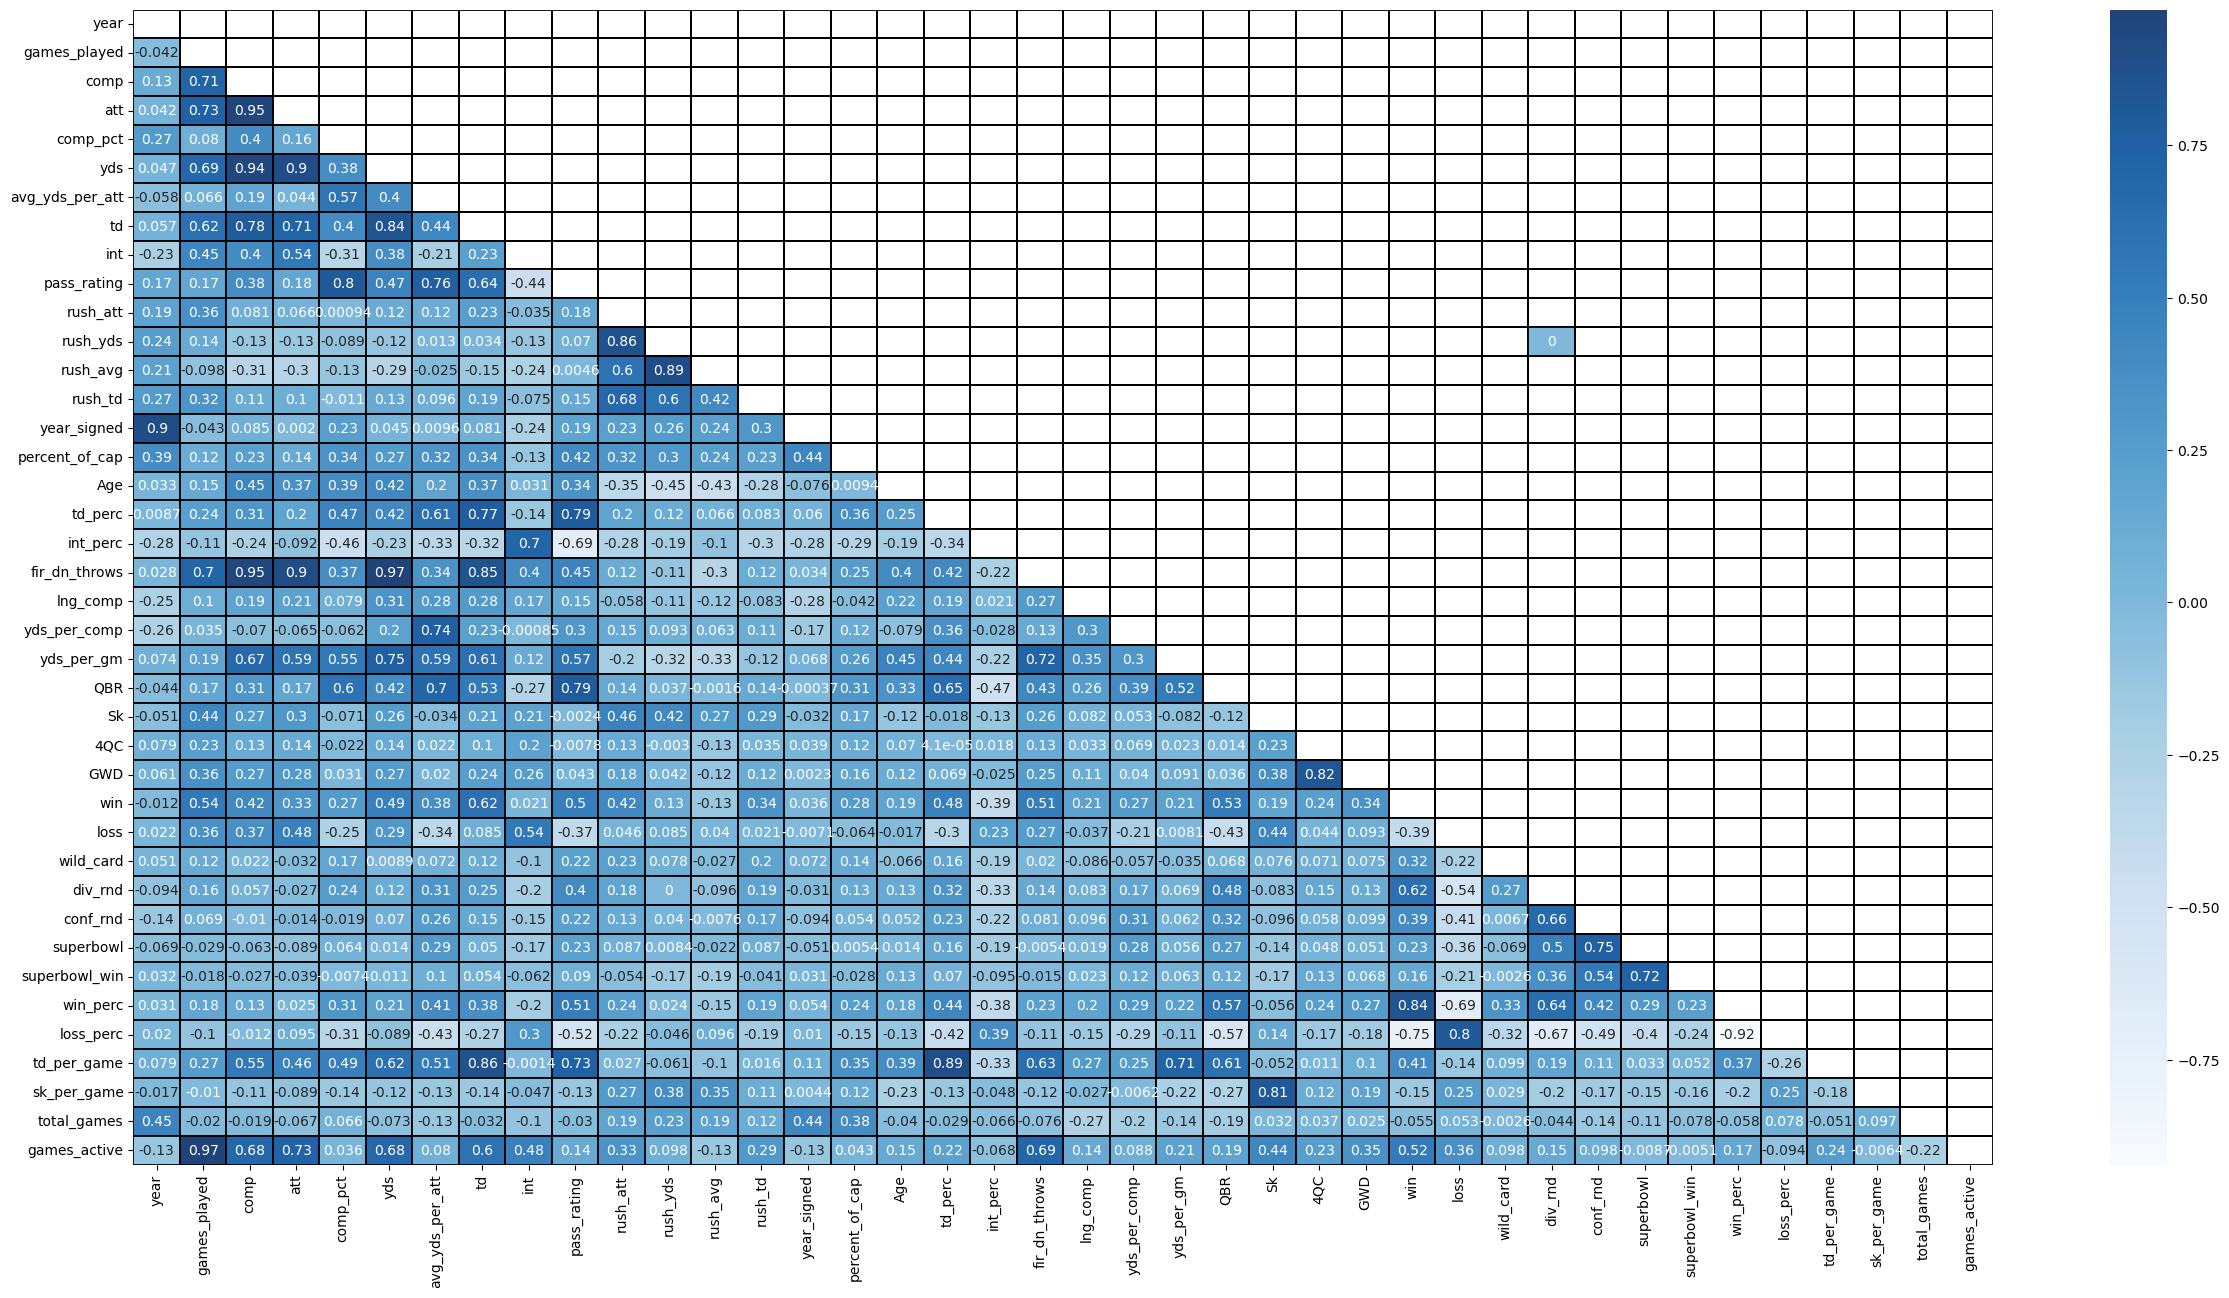

In [77]:
kwargs= {'alpha':.9, 'linewidth':.3, 'linestyle':'-',
        'linecolor':'k', 'rasterized':False, 'edgecolor':'w',
        'capstyle':'projecting',}

plt.figure(figsize=(30,15))
sns.heatmap(feature_corr, cmap='Blues', annot=True, mask = np.triu(feature_corr), **kwargs)


plt.show()

In [135]:
target = 'percent_of_cap'
columns_list = df.select_dtypes(exclude=['object']).drop(columns=target).columns.to_list()


In [136]:
columns_list

['year',
 'games_played',
 'comp',
 'att',
 'comp_pct',
 'yds',
 'avg_yds_per_att',
 'td',
 'int',
 'pass_rating',
 'rush_att',
 'rush_yds',
 'rush_avg',
 'rush_td',
 'year_signed',
 'Age',
 'td_perc',
 'int_perc',
 'fir_dn_throws',
 'lng_comp',
 'yds_per_comp',
 'yds_per_gm',
 'QBR',
 'Sk',
 '4QC',
 'GWD',
 'win',
 'loss',
 'wild_card',
 'div_rnd',
 'conf_rnd',
 'superbowl',
 'superbowl_win',
 'win_perc',
 'loss_perc',
 'td_per_game',
 'sk_per_game']

In [139]:
correlation_tests(train, columns_list, target).reset_index().drop(columns = 'index')

,feature,r,p,target
0,td,0.594521,9.192100e-26,percent_of_cap
1,win,0.585662,7.097548e-25,percent_of_cap
2,yds,0.562861,1.035786e-22,percent_of_cap
3,QBR,0.557755,3.001540e-22,percent_of_cap
4,fir_dn_throws,0.547087,2.615286e-21,percent_of_cap
5,comp,0.535583,2.480017e-20,percent_of_cap
6,pass_rating,0.531911,4.994622e-20,percent_of_cap
7,games_played,0.522319,2.988998e-19,percent_of_cap
8,win_perc,0.517915,6.669137e-19,percent_of_cap
9,td_per_game,0.507533,4.228042e-18,percent_of_cap


In [325]:
X_train, X_validate, X_test, y_train, y_validate, y_test = w.get_X_train_val_test(train, validate, test, columns_list, target)

In [140]:
drop_cols = ['Age']

In [141]:
def Xy_train_val_test(train, validate, test, target_variable, drop_cols):
    """
    input train, validate, test, after using split function()
    input target_variable as string
    drop_cols formatted as: ['col1', 'col2', 'etc'] for multiple columns
        This function will drop all 'object' columns. Identify additional 
        columns you want to drop and insert 1 column as a string or multiple
        columns in a list of strings.
    returns:
    X_train, X_validate, X_test, y_train, y_validate, y_test
    """
    
    baseline_accuracy = train[target_variable].mean()
    print(f'Baseline Accuracy: {baseline_accuracy}')
    
    X_train = train.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_validate = validate.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_test = test.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    
    y_train = train[target_variable]
    y_validate = validate[target_variable]
    y_test = test[target_variable]
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [142]:
X_train, X_validate, X_test, y_train, y_validate, y_test = Xy_train_val_test(train, validate, test, target, drop_cols)

Baseline Accuracy: 9.116078431372543


In [143]:
X_train, X_validate, X_test = w.scale_data(X_train, X_validate, X_test, cols = X_train.columns)

In [144]:
df1, df2, df3 = w.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

In [119]:
# Test df test = df[df.percent_of_cap > 6], drop_cols = ['superbowl_win']
df1

,model_train,rmse,r2
0,baseline,4.062962e+00,-2.220446e-16
1,ordinary least squared(OLS),2.760545e+00,5.383594e-01
2,lasso lars(lars),4.062962e+00,0.000000e+00
3,Polynomial Regression(poly2),2.197895e-14,1.000000e+00
4,Generalized Linear Model (GLM),2.766122e+00,5.364921e-01


In [145]:
df1

,model_train,rmse,r2
0,baseline,7.378667,0.000000
1,ordinary least squared(OLS),4.844699,0.568900
2,lasso lars(lars),7.378667,0.000000
3,Polynomial Regression(poly2),0.031311,0.999982
4,Generalized Linear Model (GLM),5.580377,0.428032


In [120]:
df2

,model_validate,rmse,r2
0,baseline,4.062962,-2.220446e-16
1,ordinary least squared(OLS),3.838644,3.027728e-01
2,lasso lars(lars),4.599655,-1.081114e-03
3,Polynomial Regression(poly2),6.533518,-1.019821e+00
4,Generalized Linear Model (GLM),3.673749,3.613871e-01


In [146]:
df2

,model_validate,rmse,r2
0,baseline,7.378667e+00,0.000000e+00
1,ordinary least squared(OLS),6.038614e+00,1.909997e-01
2,lasso lars(lars),6.819358e+00,-3.171820e-02
3,Polynomial Regression(poly2),5.442308e+07,-6.571134e+13
4,Generalized Linear Model (GLM),6.852043e+00,-4.163199e-02


In [147]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [148]:
def qb_models(train, X_train, X_validate, y_train, y_validate):
    # Baseline model, rmse, r2
    baseline = y_train.mean()
    baseline_array = np.repeat(baseline, len(train))
    rmse, r2 = metrics_reg(y_train, baseline_array)
    metrics_df = pd.DataFrame(data=[
        {
            'model': 'baseline',
            'rmse': rmse,
            'r2': r2 
        }
    ])
    
    
    # Ordinary Least Squares (OLS) model
    # make it
    lr1 = LinearRegression()
    # fit it on our RFE features
    lr1.fit(X_train, y_train)
    # use it (make predictions)
    pred_lr1 = lr1.predict(X_train)
    # use it on validate
    pred_validate_lr1 = lr1.predict(X_validate)
    # add to metrics_df
    rmse, r2 = metrics_reg(y_validate, pred_validate_lr1)
    metrics_df.loc[1] = ['ols', rmse, r2]


    # LassoLars model
    # make it
    lars = LassoLars(alpha=1, normalize=False)
    # fit it
    lars.fit(X_train, y_train)
    # use it
    pred_lars = lars.predict(X_train)
    pred_validate_lars = lars.predict(X_validate)
    rmse, r2 = metrics_reg(y_validate, pred_validate_lars)
    metrics_df.loc[2] = ['lars', rmse, r2]


    # Ploynomial Regression
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2)
    # fit and transform X_train scaled
    X_train_degree2 = pf.fit_transform(X_train)
    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(X_validate)
    
    # make it
    pr = LinearRegression()
    # fit it
    pr.fit(X_train_degree2, y_train)
    # use it
    pred_pr = pr.predict(X_train_degree2)
    pred_validate_pr = pr.predict(X_validate_degree2)
    rmse, r2 = metrics_reg(y_validate, pred_validate_pr)
    metrics_df.loc[3] = ['poly_2', rmse, r2]


    # Generalized Linear Model (GLM)
    # make it
    glm = TweedieRegressor(power=1, alpha=0)
    # fit it
    glm.fit(X_train, y_train)
    # use it 
    pred_glm = glm.predict(X_train)
    pred_validate_glm = glm.predict(X_validate)
    rmse, r2 = metrics_reg(y_validate, pred_validate_glm)
    metrics_df.loc[4] = ['glm', rmse, r2]
    
    return pred_lr1, pred_pr, pred_glm, metrics_df

In [149]:
pred_lr1, pred_pr, pred_glm, metrics_df = qb_models(train, X_train, X_validate, y_train, y_validate)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [150]:
metrics_df

,model,rmse,r2
0,baseline,7.378667e+00,0.000000e+00
1,ols,6.038614e+00,1.909997e-01
2,lars,6.659995e+00,1.593928e-02
3,poly_2,5.442308e+07,-6.571134e+13
4,glm,6.132478e+00,1.656542e-01


In [340]:
baseline = y_train.mean()

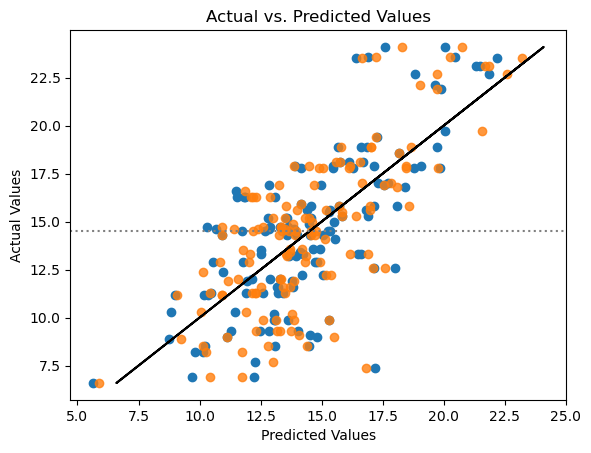

In [347]:
plt.title('Actual vs. Predicted Values')
plt.scatter(pred_lr1, y_train, label='linear regression')
# plt.scatter(pred_pr, y_train, label='ploynominal 2 deg', alpha=.8)
plt.scatter(pred_glm, y_train, label='glm', alpha=.8)
plt.plot(y_train, y_train, label='_nolegend_', color='black')

plt.axhline(baseline, ls=':', color='grey')
# plt.annotate('Baseline', (0.2, 400_000))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

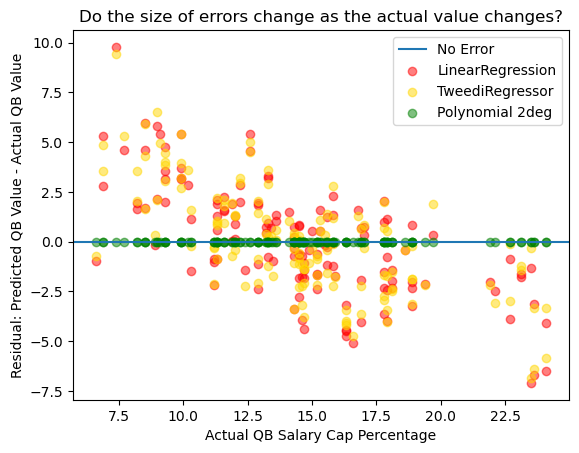

In [348]:
plt.axhline(label='No Error')

plt.scatter(y_train, pred_lr1 - y_train, alpha=.5, color='red', label='LinearRegression')
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color='gold', label='TweediRegressor')
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color='green', label='Polynomial 2deg')

plt.legend()
plt.title('Do the size of errors change as the actual value changes?')
plt.xlabel('Actual QB Salary Cap Percentage')
plt.ylabel('Residual: Predicted QB Value - Actual QB Value')

plt.show()

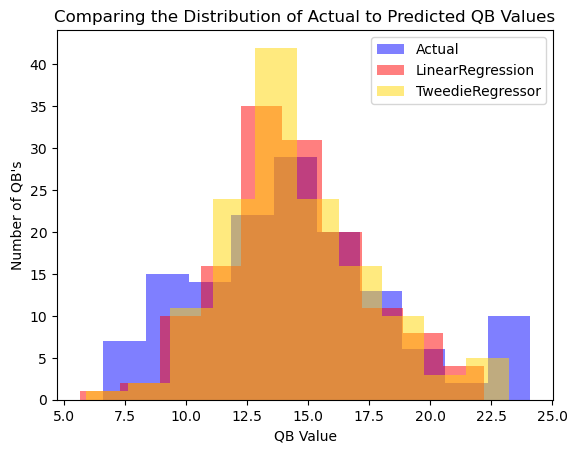

In [357]:
plt.hist(y_train, color='blue', alpha=.5, label='Actual')
plt.hist(pred_lr1, color='red', alpha=.5, label='LinearRegression')
plt.hist(pred_glm, color='gold', alpha=.5, label='TweedieRegressor')
# plt.hist(pred_pr, color='green', alpha=.5, label='Polynomial 2Deg')

plt.xlabel("QB Value")
plt.ylabel("Number of QB's")
plt.title("Comparing the Distribution of Actual to Predicted QB Values")
plt.legend()
plt.show()

## Data dictionary

year | Year that specific row of stats were collected  
games_played | The amount of games played in a specific season  
comp | Completion- Completed pass attempt  
att | Attempts- Number of passes made or attempted by the QB  
comp_pct | Completion Percentage- Percentage of completed passes vs. pass attempts  
yds | Yards- Total number of passing yards in that specific season  
avg_yds_per_att | Average Yards Per Attempt- Average yards gained per pass attempt  
td | Touchdown- highest scoring play  
int | Interception- Passing turnover, negative stat for QB's  
pass_rating | Passer Rating- one way to evaluate a QB's play performance. Scale from 0 - 158.3 higher the score the better  
rush_att | Rushing Attempts- How many times a QB ran the ball instead of passing  
rush_yds | Rushing Yards- Amount of yards gain from running the ball  
rush_avg | Rushing Average- Average yards gain from each run attempt  
rush_td | Rushing Touchdowns- The amount of touchdowns gained from running the ball  
year_signed | The year a QB signed a new contract  
percent_of_cap (target variable) | The amount of cap space allocated to the player  
age | How old the QB is that specific season  
td_perc | Touchdown Percentage- Percentage of touchdowns gained from passing attempts  
int_perc | Interception Percentage- Percentage of interceptions gained from passing attempts  
fir_dn_throws | First Down Throws- Amount of first downs a QB passes for. First down gain is a good stat for QB  
lng_comp | Longest completion- longest completed pass play  
yds_per_comp | Yards per completed pass- Average number of yards gained per completed pass  
yd_per_gm | Yards per Game- Average yards from pass completions per game  
QBR | Quarterback Rating- One way to evaluate a QB's play performance. Scale from 0 - 100 higher the score the better  
Sk | Sack- Number of times a QB was tackled for negative yards  
4QC | Fourth Quarter Comeback- The QB's team was losing but the QB took the lead or tied the game in the fourth quarter  
GWD | Game winning drive- The QB's team was tied or losing but the QB took the lead to end the game  
win | Amount of wins the QB and their team gained  
loss | Amount of losses the QB and their team gained  
wild_card | First round of the playoffs. 1 = QB played that round 0 = QB did not play that round  
div_rnd | Second round of the playoffs. 1 = QB played that round 0 = QB did not play that round  
conf_rnd | Third round of the playoffs. 1 = QB played that round 0 = QB did not play that round  
superbowl | Final round of the playoffs. 1 = QB played that round 0 = QB did not play that round  
superbowl_win | 1 = QB won the superbowl 0 = QB did not win the superbowl  
win_perc | Percentage of games that the QB won in a specific season  
loss_perc | Percentage of games that the QB lost in a specific season  
td_per_game | The average number of touchdowns a QB passed for in games played  
sk_per_game | The average number of sacks on a QB per in games played  

In [39]:
# round((df[df.year >= 2021].games_played / 17),2)

In [370]:
def show_target_var():
    plt.title('QB Salary Cap Distribution')
    sns.histplot(df.percent_of_cap, kde=True)
    plt.xlabel('Salary Cap Percent')
    plt.ylabel("Number of QB's")
    plt.show()

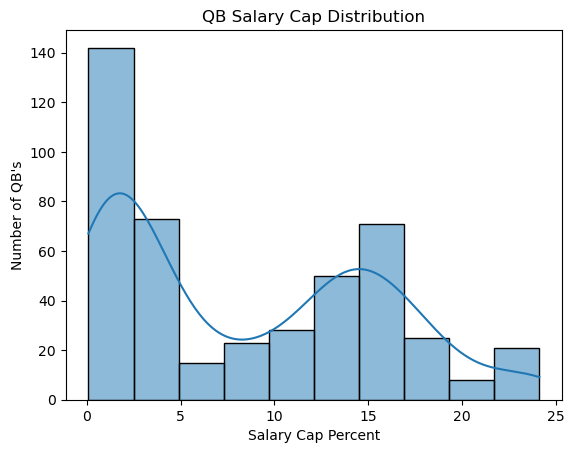

In [371]:
show_target_var()

In [159]:

from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
# rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [160]:
# rfe_feature

In [161]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


,Var,Rank
1,games_played,1
26,loss,1
33,loss_perc,2
32,win_perc,3
25,win,4
5,yds,5
3,att,6
2,comp,7
15,td_perc,8
9,pass_rating,9


In [165]:
df[df.superbowl_win==1]

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game
86,Carson Wentz,PHI,2017,13.0,265.0,440.0,60.2,3296.0,7.5,33.0,7.0,101.86,64.0,299.0,4.7,0.0,Carson Wentz,2019,17.0,Carson Wentz,25,7.5,1.6,161,72,12.4,253.5,78.5,28,1.0,1.0,11,2,0.0,1.0,1.0,1.0,1.0,0.85,0.15,2.54,2.15
130,Russell Wilson,SEA,2013,16.0,257.0,407.0,63.1,3357.0,8.2,26.0,9.0,101.15,96.0,539.0,5.6,1.0,Russell Wilson,2015,15.3,Russell Wilson,25,6.4,2.2,157,80,13.1,209.8,67.2,44,3.0,4.0,13,3,0.0,1.0,1.0,1.0,1.0,0.81,0.19,1.62,2.75
180,Patrick Mahomes,KC,2019,14.0,319.0,484.0,65.9,4031.0,8.3,26.0,5.0,105.31,43.0,218.0,5.1,2.0,Patrick Mahomes,2020,22.7,Patrick Mahomes,24,5.4,1.0,176,83,12.6,287.9,77.7,17,1.0,1.0,11,3,0.0,1.0,1.0,1.0,1.0,0.79,0.21,1.86,1.21
182,Brock Osweiler,DEN,2015,8.0,170.0,275.0,61.8,1967.0,7.2,10.0,6.0,86.43,21.0,61.0,2.9,1.0,Brock Osweiler,2016,11.6,Brock Osweiler,25,3.6,2.2,92,72,11.6,245.9,54.9,23,2.0,2.0,5,2,0.0,1.0,1.0,1.0,1.0,0.62,0.25,1.25,2.88
262,Joe Flacco,BAL,2012,16.0,317.0,531.0,59.7,3817.0,7.2,22.0,10.0,87.75,32.0,22.0,0.7,3.0,Joe Flacco,2013,16.3,Joe Flacco,27,4.1,1.9,178,61,12.0,238.6,51.1,35,3.0,3.0,10,6,1.0,1.0,1.0,1.0,1.0,0.62,0.38,1.38,2.19
286,Tom Brady,NE,2014,16.0,374.0,583.0,64.2,4109.0,7.0,33.0,9.0,97.34,36.0,57.0,1.6,0.0,Tom Brady,2016,13.2,Tom Brady,37,5.7,1.5,221,69,11.0,256.8,77.2,21,2.0,2.0,12,4,0.0,1.0,1.0,1.0,1.0,0.75,0.25,2.06,1.31
288,Tom Brady,NE,2016,12.0,291.0,432.0,67.4,3554.0,8.2,28.0,2.0,112.17,28.0,64.0,2.3,0.0,Tom Brady,2016,13.2,Tom Brady,39,6.5,0.5,165,79,12.2,296.2,79.4,15,1.0,1.0,11,1,0.0,1.0,1.0,1.0,1.0,0.92,0.08,2.33,1.25
290,Tom Brady,NE,2018,16.0,375.0,570.0,65.8,4355.0,7.6,29.0,11.0,97.66,23.0,35.0,1.5,2.0,Tom Brady,2019,12.2,Tom Brady,41,5.1,1.9,205,63,11.6,272.2,68.4,21,1.0,2.0,11,5,0.0,1.0,1.0,1.0,1.0,0.69,0.31,1.81,1.31
292,Tom Brady,TB,2020,16.0,401.0,610.0,65.7,4633.0,7.6,40.0,12.0,102.17,30.0,6.0,0.2,3.0,Tom Brady,2020,12.6,Tom Brady,43,6.6,2.0,233,50,11.6,289.6,66.0,21,3.0,3.0,11,5,1.0,1.0,1.0,1.0,1.0,0.69,0.31,2.50,1.31
300,Eli Manning,NYG,2011,16.0,358.0,588.0,60.9,4910.0,8.4,29.0,16.0,92.72,35.0,15.0,0.4,1.0,Eli Manning,2015,14.7,Eli Manning,30,4.9,2.7,218,99,13.7,308.3,64.2,28,5.0,6.0,9,7,1.0,1.0,1.0,1.0,1.0,0.56,0.44,1.81,1.75


In [191]:
master_df['wild_card'] = np.where(master_df.wild_card==0, master_df.div_rnd, master_df.wild_card)

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1.